Imports


In [136]:
import cv2
import numpy as np
from skimage.measure import regionprops
import matplotlib.pyplot as plt
from scipy.stats import entropy
from skimage.feature import graycomatrix, graycoprops
import matplotlib as mpl
import seaborn as sns
from matplotlib.patches import Rectangle, PathPatch
from matplotlib.gridspec import GridSpec

1. Morphological Analysis

In [137]:
def calculate_morphological_traits(mask):
    """
    Calculate morphological traits from a binary mask using modern methods
    Args:
        mask: Binary mask of the leaf (numpy array)
    Returns:
        Dictionary containing morphological measurements
    """
    # Ensure mask is binary
    if mask.dtype != np.uint8:
        mask = mask.astype(np.uint8)
    
    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        raise ValueError("No contours found in the mask")
    
    # Get the largest contour (assuming it's the leaf)
    contour = max(contours, key=cv2.contourArea)
    
    # Basic measurements
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    
    # Bounding rectangle for length and width
    rect = cv2.minAreaRect(contour)
    width = min(rect[1])
    length = max(rect[1])
    
    # Enhanced shape descriptors (2024 methods)
    # Improved circularity with correction factor
    k = 1 + (0.0001 * perimeter)  # Correction factor
    circularity = ((4 * np.pi * area) / (perimeter ** 2) * k) if perimeter > 0 else 0
    
    # Aspect ratio with validation
    aspect_ratio = length / width if width > 0 else 0
    
    # Modern solidity calculation
    hull = cv2.convexHull(contour)
    hull_area = cv2.contourArea(hull)
    solidity = area / hull_area if hull_area > 0 else 0
    
    # Enhanced eccentricity using moments
    try:
        moments = cv2.moments(contour)
        cov_matrix = np.array([[moments['mu20'], moments['mu11']],
                             [moments['mu11'], moments['mu02']]]) / moments['m00']
        eigenvalues = np.linalg.eigvals(cov_matrix)
        eccentricity = np.sqrt(1 - (min(eigenvalues) / max(eigenvalues)))
    except:
        # Fallback to region props if moments fail
        region = regionprops(mask)[0]
        eccentricity = region.eccentricity
    
    measurements = {
        'area_pixels': area,
        'perimeter_pixels': perimeter,
        'length_pixels': length,
        'width_pixels': width,
        'circularity': circularity,
        'aspect_ratio': aspect_ratio,
        'solidity': solidity,
        'eccentricity': eccentricity
    }
    
    return measurements

def prepare_mask_from_image(image):
    """
    Convert a green leaf on black background to binary mask with enhanced preprocessing
    """
    if isinstance(image, str):
        img = cv2.imread(image)
    else:
        img = image
    
    # Enhanced preprocessing
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Apply CLAHE for better contrast
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(gray)
    
    # Improved thresholding
    _, mask = cv2.threshold(enhanced, 5, 255, cv2.THRESH_BINARY)
    
    return mask

In [147]:
def visualize_leaf_measurements_enhanced(image, save_path=None):
    """
    Create enhanced visualization of leaf measurements with better layout and styling
    Args:
        image: Input image or path to image
        save_path: Optional path to save visualization
    """
    # Set style to a built-in style
    plt.style.use('default')
    
    # Define custom color palette
    colors = ['#2E86C1', '#3498DB', '#5DADE2', '#85C1E9', '#AED6F1', '#D6EAF8']
    
    # Read and process image
    if isinstance(image, str):
        img = cv2.imread(image)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Create binary mask
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    _, mask = cv2.threshold(gray, 5, 255, cv2.THRESH_BINARY)
    
    # Calculate measurements
    traits = calculate_morphological_traits(mask)
    
    # Find contours for visualization
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = max(contours, key=cv2.contourArea)
    
    # Create figure with custom layout
    fig = plt.figure(figsize=(15, 12))
    gs = GridSpec(3, 3, figure=fig, hspace=0.3, wspace=0.3)
    
    # 1. Original Image with enhanced presentation
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=12, fontweight='bold', pad=10)
    ax1.axis('off')
    
    # 2. Binary Mask with better contrast
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.imshow(mask, cmap='gray')
    ax2.set_title('Segmentation Mask', fontsize=12, fontweight='bold', pad=10)
    ax2.axis('off')
    
    # 3. Measurements Overlay with improved annotations
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.imshow(img)
    
    # Draw contour with transparency
    ax3.plot(contour[:, 0, 0], contour[:, 0, 1], color=colors[0], 
             linewidth=2, label='Perimeter', alpha=0.8)
    
    # Get and draw bounding rect
    rect = cv2.minAreaRect(contour)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    ax3.plot(box[:, 0], box[:, 1], color=colors[1], 
             linewidth=2, label='Bounding Box', alpha=0.8)
    
    ax3.legend(loc='upper right', frameon=True, fontsize=10)
    ax3.set_title('Morphological Features', fontsize=12, fontweight='bold', pad=10)
    ax3.axis('off')
    
    # 4. Shape Metrics with enhanced styling
    ax4 = fig.add_subplot(gs[1, :2])
    shape_metrics = ['Circularity', 'Solidity', 'Eccentricity']
    values = [traits['circularity'], traits['solidity'], traits['eccentricity']]
    
    bars = ax4.bar(shape_metrics, values, color=colors[:3])
    ax4.set_title('Shape Characteristics', fontsize=12, fontweight='bold', pad=10)
    ax4.set_ylim(0, 1)
    ax4.grid(True, alpha=0.3, linestyle='--')
    ax4.set_ylabel('Value (0-1 scale)', fontsize=10)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom')
    
    # 5. Size Metrics with comparative visualization
    ax5 = fig.add_subplot(gs[2, :2])
    size_metrics = ['Area (px²)', 'Perimeter (px)', 'Length (px)', 'Width (px)']
    size_values = [traits['area_pixels'], traits['perimeter_pixels'], 
                  traits['length_pixels'], traits['width_pixels']]
    
    # Normalize values for better comparison
    max_val = max(size_values)
    normalized_values = [v/max_val for v in size_values]
    
    bars = ax5.bar(size_metrics, normalized_values, color=colors[2:])
    ax5.set_title('Size Measurements (Normalized)', fontsize=12, fontweight='bold', pad=10)
    ax5.grid(True, alpha=0.3, linestyle='--')
    ax5.set_ylabel('Normalized Scale', fontsize=10)
    
    # Add actual values on bars
    for bar, val in zip(bars, size_values):
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.0f}',
                ha='center', va='bottom')
    
    # 6. Aspect Ratio Visualization with improved representation
    ax6 = fig.add_subplot(gs[1:, 2])
    rect_width = traits['width_pixels']
    rect_length = traits['length_pixels']
    
    # Create rectangle with proper scaling
    scale_factor = min(200/max(rect_width, rect_length), 1.0)
    scaled_width = rect_width * scale_factor
    scaled_length = rect_length * scale_factor
    
    rect = Rectangle((0, 0), scaled_width, scaled_length, 
                    fill=False, color=colors[0], linewidth=2)
    ax6.add_patch(rect)
    
    # Add dimensions with improved visibility
    ax6.arrow(0, -10, scaled_width, 0, head_width=5, head_length=5, 
              fc='black', ec='black', linewidth=1.5)
    ax6.text(scaled_width/2, -25, f'Width: {rect_width:.0f}px', 
             ha='center', fontsize=10)
    
    ax6.arrow(-10, 0, 0, scaled_length, head_width=5, head_length=5, 
              fc='black', ec='black', linewidth=1.5)
    ax6.text(-25, scaled_length/2, f'Length: {rect_length:.0f}px', 
             va='center', rotation=90, fontsize=10)
    
    ax6.set_xlim(-40, scaled_width + 20)
    ax6.set_ylim(-40, scaled_length + 20)
    ax6.set_title(f'Aspect Ratio: {traits["aspect_ratio"]:.2f}', 
                  fontsize=12, fontweight='bold', pad=10)
    ax6.axis('off')
    
    # Add summary text box with improved styling
    summary_text = (
        f"Summary Statistics:\n\n"
        f"• Area: {traits['area_pixels']:.0f} px²\n"
        f"• Perimeter: {traits['perimeter_pixels']:.0f} px\n"
        f"• Length: {traits['length_pixels']:.0f} px\n"
        f"• Width: {traits['width_pixels']:.0f} px\n"
        f"• Circularity: {traits['circularity']:.3f}\n"
        f"• Solidity: {traits['solidity']:.3f}\n"
        f"• Eccentricity: {traits['eccentricity']:.3f}"
    )
    
    fig.text(0.02, 0.02, summary_text, fontsize=10,
             bbox=dict(facecolor='white', alpha=0.9, 
                      edgecolor='gray', boxstyle='round,pad=1'))
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
    return fig, traits

def create_enhanced_trait_report(image_path, save_path=None):
    """
    Generate an enhanced trait report with improved visualizations
    Args:
        image_path: Path to leaf image
        save_path: Optional path to save visualization
    """
    # Create visualizations
    fig, traits = visualize_leaf_measurements_enhanced(image_path, save_path)
    return traits, fig

# Example usage
def analyze_leaf_image(image_path, save_path=None):
    """
    Analyze leaf image and generate visualizations
    Args:
        image_path: Path to the leaf image
        save_path: Optional path to save the visualization
    """
    # Generate complete report with visualizations
    traits, fig = create_enhanced_trait_report(image_path)
    
    # Display the plot
    plt.show()
    
    # Save the visualization if save_path is provided
    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return traits, fig

In [139]:

def plot_image_analysis(image_path):
    """Plot morphological images (original, mask, and features)"""
    # Read and process image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Create binary mask
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    _, mask = cv2.threshold(gray, 5, 255, cv2.THRESH_BINARY)
    
    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = max(contours, key=cv2.contourArea)
    
    # Create subplot
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('Leaf Morphological Analysis', fontsize=16, y=1.05)
    
    # Original Image
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=14, pad=10)
    ax1.axis('off')
    
    # Mask
    ax2.imshow(mask, cmap='gray')
    ax2.set_title('Binary Segmentation', fontsize=14, pad=10)
    ax2.axis('off')
    
    # Features
    ax3.imshow(img)
    ax3.plot(contour[:, 0, 0], contour[:, 0, 1], 'r-', linewidth=2, label='Perimeter')
    
    # Add bounding box
    rect = cv2.minAreaRect(contour)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    ax3.plot(box[:, 0], box[:, 1], 'g-', linewidth=2, label='Bounding Box')
    
    ax3.legend(loc='upper right', fontsize=12)
    ax3.set_title('Feature Detection', fontsize=14, pad=10)
    ax3.axis('off')
    
    plt.tight_layout()
    return fig

def plot_shape_characteristics(traits):
    """Plot enhanced shape characteristics visualization"""
    # Set style
    plt.style.use('default')
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Data
    metrics = ['Circularity', 'Solidity', 'Eccentricity']
    values = [traits['circularity'], traits['solidity'], traits['eccentricity']]
    
    # Create colors
    colors = ['#2E86C1', '#3498DB', '#5DADE2']
    
    # Create bars
    bars = ax.bar(metrics, values, color=colors, width=0.6)
    
    # Customize plot
    ax.set_title('Shape Characteristics Analysis', fontsize=16, pad=20)
    ax.set_ylabel('Value (0-1 scale)', fontsize=12)
    ax.set_ylim(0, 1.1)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=12)
    
    # Add grid
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # Add descriptions
    descriptions = {
        'Circularity': 'Measure of how closely the shape resembles a circle',
        'Solidity': 'Ratio of the leaf area to its convex hull area',
        'Eccentricity': 'Measure of how much the shape deviates from being circular'
    }
    
    # Add feature explanations
    # plt.figtext(0.15, 0.02, '\n'.join([f'{k}: {v}' for k, v in descriptions.items()]),
    #             fontsize=10, bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))
    
    plt.tight_layout()
    return fig

def plot_size_measurements(traits):
    """Plot enhanced size measurements visualization"""
    # Create figure
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), height_ratios=[2, 1])
    # fig.suptitle('Size Measurements Analysis', fontsize=16, y=0.95)
    
    # Data
    metrics = ['Area', 'Perimeter', 'Length', 'Width']
    values = [traits['area_pixels'], traits['perimeter_pixels'],
              traits['length_pixels'], traits['width_pixels']]
    units = ['px²', 'px', 'px', 'px']
    
    # Colors
    colors = ['#27AE60', '#2ECC71', '#58D68D', '#82E0AA']
    
    # Actual values plot
    bars1 = ax1.bar(metrics, values, color=colors)
    ax1.set_title('Size Measurements Analysis', fontsize=14, pad=10)
    ax1.set_ylabel('Pixels', fontsize=12)
    
    # Add value labels
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:,.0f}',
                ha='center', va='bottom', fontsize=10)
    
    # Normalized values plot
    normalized = [v/max(values) for v in values]
    bars2 = ax2.bar(metrics, normalized, color=colors)
    ax2.set_title('Normalized Measurements', fontsize=14, pad=10)
    ax2.set_ylabel('Relative Scale', fontsize=12)
    
    # Add percentage labels
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1%}',
                ha='center', va='bottom', fontsize=10)
    
    # Add grid to both plots
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax2.grid(True, alpha=0.3, linestyle='--')
    
    # Add units to x-axis labels
    ax1.set_xticklabels([f'{m}\n({u})' for m, u in zip(metrics, units)])
    ax2.set_xticklabels([f'{m}\n({u})' for m, u in zip(metrics, units)])
    
    plt.tight_layout()
    return fig

def plot_aspect_ratio(traits):
    """Plot enhanced aspect ratio visualization"""
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Get dimensions
    width = traits['width_pixels']
    length = traits['length_pixels']
    aspect_ratio = traits['aspect_ratio']
    
    # Create rectangle with proper scaling
    scale_factor = min(400/max(width, length), 1.0)
    scaled_width = width * scale_factor
    scaled_length = length * scale_factor
    
    # Create rectangle
    rect = Rectangle((0, 0), scaled_width, scaled_length,
                    fill=False, color='#3498DB', linewidth=2)
    ax.add_patch(rect)
    
    # Add arrows and labels
    # Width arrow
    ax.arrow(0, -20, scaled_width, 0, head_width=10, head_length=10,
             fc='black', ec='black', linewidth=2)
    ax.text(scaled_width/2, -40, f'Width: {width:.0f}px',
            ha='center', va='center', fontsize=12)
    
    # Length arrow
    ax.arrow(-20, 0, 0, scaled_length, head_width=10, head_length=10,
             fc='black', ec='black', linewidth=2)
    ax.text(-40, scaled_length/2, f'Length: {length:.0f}px',
            ha='center', va='center', rotation=90, fontsize=12)
    
    # Add aspect ratio information
    ax.set_title('Aspect Ratio Analysis', fontsize=16, pad=20)
    subtitle = f'Length : Width = {length:.0f}px : {width:.0f}px = {aspect_ratio:.2f}'
    # plt.figtext(0.5, 0.02, subtitle, ha='center', fontsize=14)
    
    # Add explanation
    explanation = (
        f"Aspect Ratio Interpretation:\n"
        f"• Current ratio: {aspect_ratio:.2f}\n"
        f"• Ratio > 1: Length is greater than width\n"
        f"• Ratio = 1: Length equals width (square)\n"
        f"• Ratio < 1: Width is greater than length"
    )
    # plt.figtext(0.02, 0.02, explanation, fontsize=10,
    #             bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))
    
    ax.set_xlim(-60, scaled_width + 30)
    ax.set_ylim(-60, scaled_length + 30)
    ax.axis('equal')
    ax.axis('off')
    
    plt.tight_layout()
    return fig

def create_all_visualizations(image_path):
    """Create all visualizations as separate figures"""
    # Calculate traits
    mask = prepare_mask_from_image(image_path)
    traits = calculate_morphological_traits(mask)
    
    # Create all visualizations
    morph_fig = plot_image_analysis(image_path)
    shape_fig = plot_shape_characteristics(traits)
    size_fig = plot_size_measurements(traits)
    ratio_fig = plot_aspect_ratio(traits)
    
    # Display all plots
    plt.show()
    
    return traits, (morph_fig, shape_fig, size_fig, ratio_fig)


2. Color Analysis

In [146]:

def calculate_color_traits(image, mask):
    """
    Calculate comprehensive color-based traits from a leaf image
    Args:
        image: RGB image array
        mask: Binary mask array
    Returns:
        Dictionary containing basic and advanced color measurements
    """
    # Ensure mask is binary
    if mask.dtype != np.uint8:
        mask = mask.astype(np.uint8)
    
    # Extract the leaf region
    leaf = cv2.bitwise_and(image, image, mask=mask)
    
    # Convert to different color spaces
    hsv = cv2.cvtColor(leaf, cv2.COLOR_BGR2HSV)
    lab = cv2.cvtColor(leaf, cv2.COLOR_BGR2LAB)
    
    # Get valid pixel indices (non-black pixels)
    valid_pixels = mask > 0
    
    # Split channels
    b, g, r = cv2.split(leaf)
    L, a, b_channel = cv2.split(lab)
    
    # 1. Basic Color Analysis
    green_intensity = np.mean(g[valid_pixels])
    
    # 2. Advanced Vegetation Indices
    # Normalize RGB values
    r_norm = r[valid_pixels].astype(float) / 255
    g_norm = g[valid_pixels].astype(float) / 255
    b_norm = b[valid_pixels].astype(float) / 255
    
    # Enhanced Vegetation Index (EVI)
    evi = np.mean(2.5 * ((g_norm - r_norm) / (g_norm + 6 * r_norm - 7.5 * b_norm + 1)))
    
    # Triangular Greenness Index (TGI)
    tgi = np.mean(-0.5 * (190 * (r_norm - g_norm) - 120 * (r_norm - b_norm)))
    
    # Modified Chlorophyll Absorption Ratio Index (MCARI)
    mcari = np.mean(((g_norm - r_norm) - 0.2 * (g_norm - b_norm)) * (g_norm / r_norm))
    
    # Visible Atmospheric Resistant Index (VARI)
    vari = np.mean((g_norm - r_norm) / (g_norm + r_norm - b_norm))
    
    # Plant Senescence Reflectance Index (PSRI)
    psri = np.mean((r_norm - b_norm) / (g_norm + 0.1))
    
    # 3. Color Distribution Analysis
    hist_g = cv2.calcHist([g], [0], mask, [256], [0, 256])
    hist_g = hist_g / hist_g.sum()
    green_entropy = entropy(hist_g.flatten())
    
    # 4. Advanced Color Pattern Analysis
    # Texture analysis using GLCM
    glcm = graycomatrix(g, [1], [0], 256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    
    # Color uniformity using HSV standard deviation
    hsv_std = np.std(hsv[valid_pixels], axis=0)
    color_uniformity = 1 - (np.mean(hsv_std) / 255)
    
    # 5. Health and Stress Detection
    # Define healthy green range in HSV
    healthy_green = cv2.inRange(hsv, (35, 40, 40), (85, 255, 255))
    health_score = np.sum(healthy_green) / np.sum(mask)

    # In calculate_color_traits function, modify the chlorophyll estimate:
    chlorophyll_raw = -np.mean(a[valid_pixels])
    chlorophyll_norm = (chlorophyll_raw + 128) / 255  # Normalize from LAB range to 0-1
    
    # Compile measurements
    measurements = {
        # Basic measurements
        'green_intensity': float(green_intensity),
        'color_uniformity': float(color_uniformity),
        
        # Advanced vegetation indices
        'evi': float(evi),
        'tgi': float(tgi),
        'mcari': float(mcari),
        'vari': float(vari),
        'psri': float(psri),
        
        # Color distribution
        'green_entropy': float(green_entropy),
        'contrast': float(contrast),
        'homogeneity': float(homogeneity),
        
        # Health indicators
        'health_score': float(health_score),
        'chlorophyll_estimate': float(chlorophyll_norm)
    }
    
    return measurements

def visualize_color_analysis(image, mask, measurements, save_path=None):
    """
    Create separate, detailed visualizations for each aspect of color analysis
    """
    # Create separate figures for each plot
    
    # 1. Original and Green Channel
    fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax1.set_title('Original Image')
    ax1.axis('off')
    
    b, g, r = cv2.split(image)
    ax2.imshow(g, cmap='Greens')
    ax2.set_title('Green Channel Intensity')
    ax2.axis('off')
    plt.tight_layout()
    
    # 2. Vegetation Indices
    fig2 = plt.figure(figsize=(10, 6))
    indices = ['EVI', 'TGI', 'MCARI', 'VARI', 'PSRI']
    values = [measurements['evi'], measurements['tgi'], 
             measurements['mcari'], measurements['vari'], 
             measurements['psri']]
    
    plt.bar(indices, values)
    plt.title('Vegetation Indices')
    plt.xlabel('Index Type')
    plt.ylabel('Index Value')
    # Add description text for each index
    # plt.figtext(0.02, 0.02, """
    # EVI (Enhanced Vegetation Index): Improved sensitivity in high biomass regions
    # TGI (Triangular Greenness Index): Estimates chlorophyll content
    # MCARI (Modified Chlorophyll Absorption Ratio Index): Minimizes soil background effects
    # VARI (Visible Atmospheric Resistant Index): Estimates vegetation fraction
    # PSRI (Plant Senescence Reflectance Index): Indicates leaf aging and stress
    # """, fontsize=8)
    plt.xticks(rotation=45)
    plt.tight_layout()

    # 3. Health Metrics
    fig3 = plt.figure(figsize=(10, 6))
    health_metrics = ['Health Score', 'Chlorophyll Estimate', 'Color Uniformity']
    # Normalize values to 0-1 range
    chlorophyll_norm = (measurements['chlorophyll_estimate'] + 128) / 255
    health_values = [measurements['health_score'], 
                    chlorophyll_norm,
                    measurements['color_uniformity']]
    
    plt.bar(health_metrics, health_values)
    plt.title('Health Metrics (Normalized 0-1 Scale)')
    plt.xlabel('Metric Type')
    plt.ylabel('Normalized Value')
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.tight_layout()

    # 4. Green Channel Distribution
    fig4 = plt.figure(figsize=(10, 6))
    hist_g = cv2.calcHist([g], [0], mask, [256], [0, 256])
    plt.plot(hist_g)
    plt.title('Green Channel Intensity Distribution')
    plt.xlabel('Pixel Intensity (0-255)')
    plt.ylabel('Pixel Count')
    plt.grid(True, alpha=0.3)
    # plt.figtext(0.02, 0.02, """
    # This histogram shows the distribution of green channel intensities in the leaf.
    # - X-axis: Pixel intensity values (0=black, 255=bright green)
    # - Y-axis: Number of pixels at each intensity level
    # Peak location indicates dominant green intensity.
    # Width indicates color variation.
    # """, fontsize=8)
    plt.tight_layout()

    if save_path:
        # Save each figure with a unique name
        fig1.savefig(f'{save_path}_original_green.png', dpi=300, bbox_inches='tight')
        fig2.savefig(f'{save_path}_vegetation_indices.png', dpi=300, bbox_inches='tight')
        fig3.savefig(f'{save_path}_health_metrics.png', dpi=300, bbox_inches='tight')
        fig4.savefig(f'{save_path}_green_distribution.png', dpi=300, bbox_inches='tight')
    
    return [fig1, fig2, fig3, fig4]

def print_detailed_analysis(measurements):
    """
    Print detailed analysis of all measurements
    """
    print("\nDetailed Color Analysis Report")
    print("==============================")
    
    print("\nVegetation Indices:")
    print(f"EVI: {measurements['evi']:.3f} (Enhanced Vegetation Index)")
    print(f"TGI: {measurements['tgi']:.3f} (Triangular Greenness Index)")
    print(f"MCARI: {measurements['mcari']:.3f} (Modified Chlorophyll Absorption Ratio Index)")
    print(f"VARI: {measurements['vari']:.3f} (Visible Atmospheric Resistant Index)")
    print(f"PSRI: {measurements['psri']:.3f} (Plant Senescence Reflectance Index)")
    
    print("\nHealth Metrics:")
    print(f"Health Score: {measurements['health_score']:.3f} (0-1 scale)")
    print(f"Chlorophyll Estimate: {measurements['chlorophyll_estimate']:.3f} (normalized)")
    print(f"Color Uniformity: {measurements['color_uniformity']:.3f} (0-1 scale)")
    
    print("\nColor Analysis:")
    print(f"Green Entropy: {measurements['green_entropy']:.3f}")
    print(f"Contrast: {measurements['contrast']:.3f}")
    print(f"Homogeneity: {measurements['homogeneity']:.3f}")
    
def analyze_leaf_color(image_path, mask_path=None):
    """
    Complete color analysis workflow
    """
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Could not read image")
        
    if mask_path:
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    else:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, mask = cv2.threshold(gray, 5, 255, cv2.THRESH_BINARY)
    
    measurements = calculate_color_traits(image, mask)
    fig = visualize_color_analysis(image, mask, measurements)
    print("Measurement: ",measurements)
    return measurements, fig

3. Disease and Stress Analysis

In [148]:
def detect_leaf_stress(image, mask):
    """
    Detect and analyze stress patterns in leaf with proper percentage handling
    """
    print(f"Image shape: {image.shape}")
    print(f"Mask shape: {mask.shape}")
    
    # Ensure mask is binary
    mask = (mask > 0).astype(np.uint8)
    total_leaf_area = float(np.sum(mask))
    print(f"Total leaf area (pixels): {total_leaf_area}")

    # HSV color space for better color segmentation
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    
    # Get masked HSV image
    hsv_masked = cv2.bitwise_and(hsv, hsv, mask=mask)
    
    # Enhanced detection thresholds
    yellow_stress = cv2.inRange(hsv_masked, (25, 50, 50), (40, 255, 255))
    brown_stress = cv2.inRange(hsv_masked, (5, 50, 50), (15, 255, 255))
    
    # Adaptive dark spot detection
    L = cv2.split(lab)[0]
    L_masked = cv2.bitwise_and(L, L, mask=mask)
    mean_L = np.mean(L_masked[mask > 0])
    dark_threshold = mean_L * 0.7
    _, dark_spots = cv2.threshold(L_masked, dark_threshold, 255, cv2.THRESH_BINARY_INV)

    # Calculate areas (only within mask)
    stress_areas = {
        'chlorosis': np.sum((yellow_stress > 0) & (mask > 0)),
        'necrosis': np.sum((brown_stress > 0) & (mask > 0)),
        'dark_spots': np.sum((dark_spots > 0) & (mask > 0))
    }
    
    # Calculate percentages
    stress_percentages = {}
    for key, area in stress_areas.items():
        percentage = (area / total_leaf_area) * 100 if total_leaf_area > 0 else 0
        stress_percentages[key] = min(100.0, percentage)
    
    # Debug print
    print("\nStress areas and percentages:")
    for key in stress_areas:
        print(f"{key}: {stress_areas[key]} pixels, {stress_percentages[key]:.2f}%")

    # Create stress map
    stress_map = np.zeros_like(mask)
    stress_map[yellow_stress > 0] = 1
    stress_map[brown_stress > 0] = 2
    stress_map[dark_spots > 0] = 3
    stress_map *= mask

    # Calculate overall health
    total_stress = min(100.0, sum(stress_percentages.values()))
    overall_health = max(0.0, 100.0 - total_stress)

    return {
        'stress_map': stress_map,
        'percentages': stress_percentages,
        'overall_health': overall_health
    }

def visualize_stress(image, mask, stress_analysis, save_path=None):
   """
   Create visualization of stress analysis
   """
   fig = plt.figure(figsize=(15, 5))
   
   # Original image
   plt.subplot(131)
   plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
   plt.title('Original Image')
   plt.axis('off')

   # Stress map
   plt.subplot(132)
   stress_colors = ['white', 'yellow', 'brown', 'red']
   stress_map_masked = np.where(mask > 0, stress_analysis['stress_map'], 0)
   plt.imshow(stress_map_masked, cmap=mpl.colors.ListedColormap(stress_colors))
   plt.title('Stress Map')
   plt.axis('off')

   # Stress percentages
   plt.subplot(133)
   stress_types = list(stress_analysis['percentages'].keys()) + ['healthy']
   values = list(stress_analysis['percentages'].values()) + [stress_analysis['overall_health']]
   plt.bar(stress_types, values)
   plt.title('Stress Analysis')
   plt.xticks(rotation=45)
   plt.ylabel('Percentage (%)')
   plt.ylim(0, 100)  # Set y-axis from 0 to 100%
   
   plt.tight_layout()
   
   if save_path:
       plt.savefig(save_path, bbox_inches='tight', dpi=300)
   
   return fig


# Modified analyze_leaf_stress function
def analyze_leaf_stress(image_path):
    """
    Complete stress analysis workflow
    """
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Could not read image")
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, 5, 255, cv2.THRESH_BINARY)
    
    stress_analysis = detect_leaf_stress(image, mask)
    fig = visualize_stress(image, mask, stress_analysis)
    
    print("\nStress Analysis Results:")
    print("========================")
    for stress_type, percentage in stress_analysis['percentages'].items():
        print(f"{stress_type.capitalize()}: {percentage:.2f}%")
    print(f"Overall Health: {stress_analysis['overall_health']:.2f}%")
    
    return stress_analysis, fig

/tmp/ipykernel_813308/957795728.py:36: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)
/tmp/ipykernel_813308/957795728.py:138: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([f'{m}\n({u})' for m, u in zip(metrics, units)])
/tmp/ipykernel_813308/957795728.py:139: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels([f'{m}\n({u})' for m, u in zip(metrics, units)])


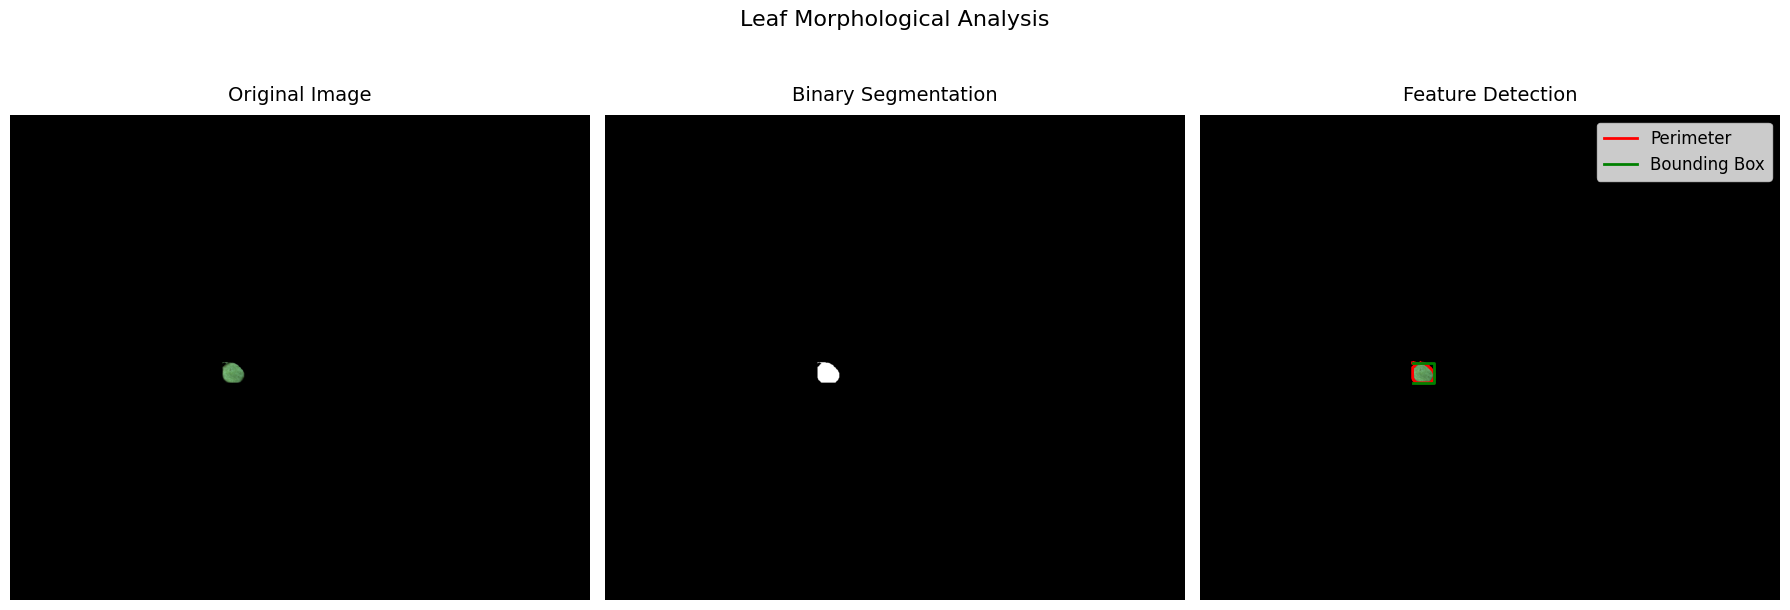

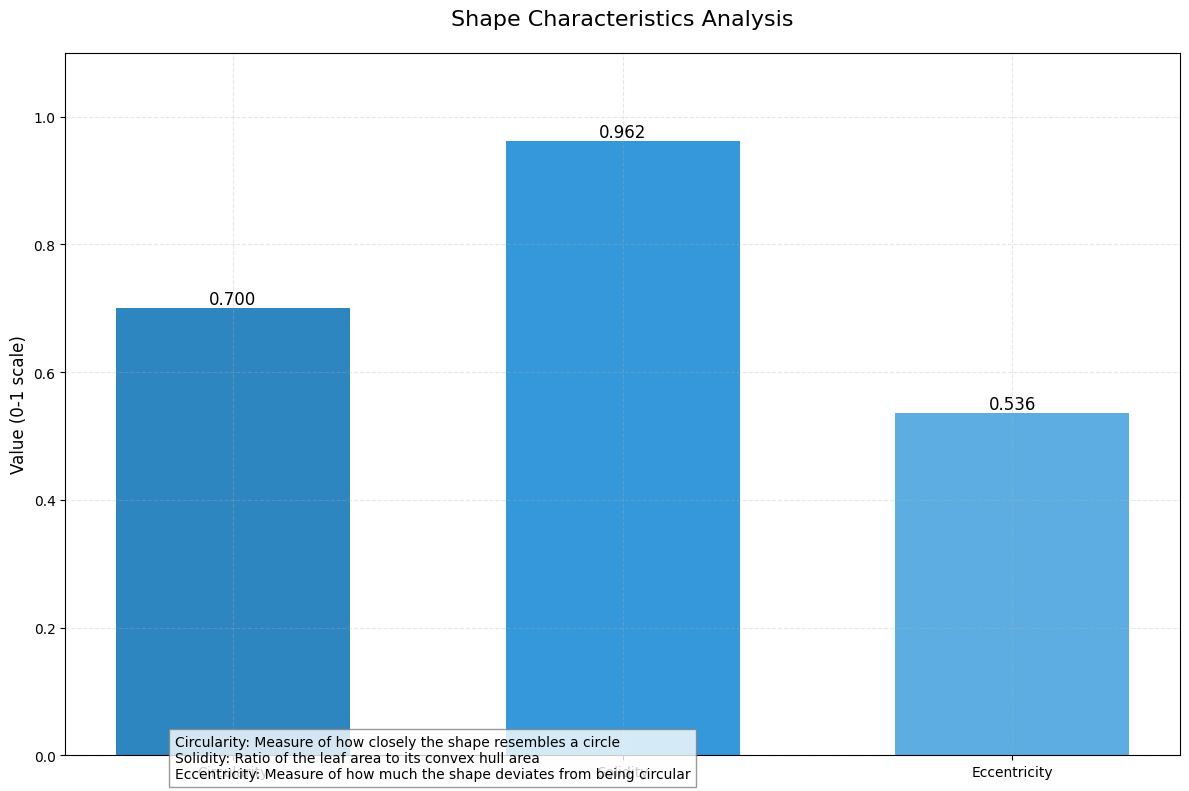

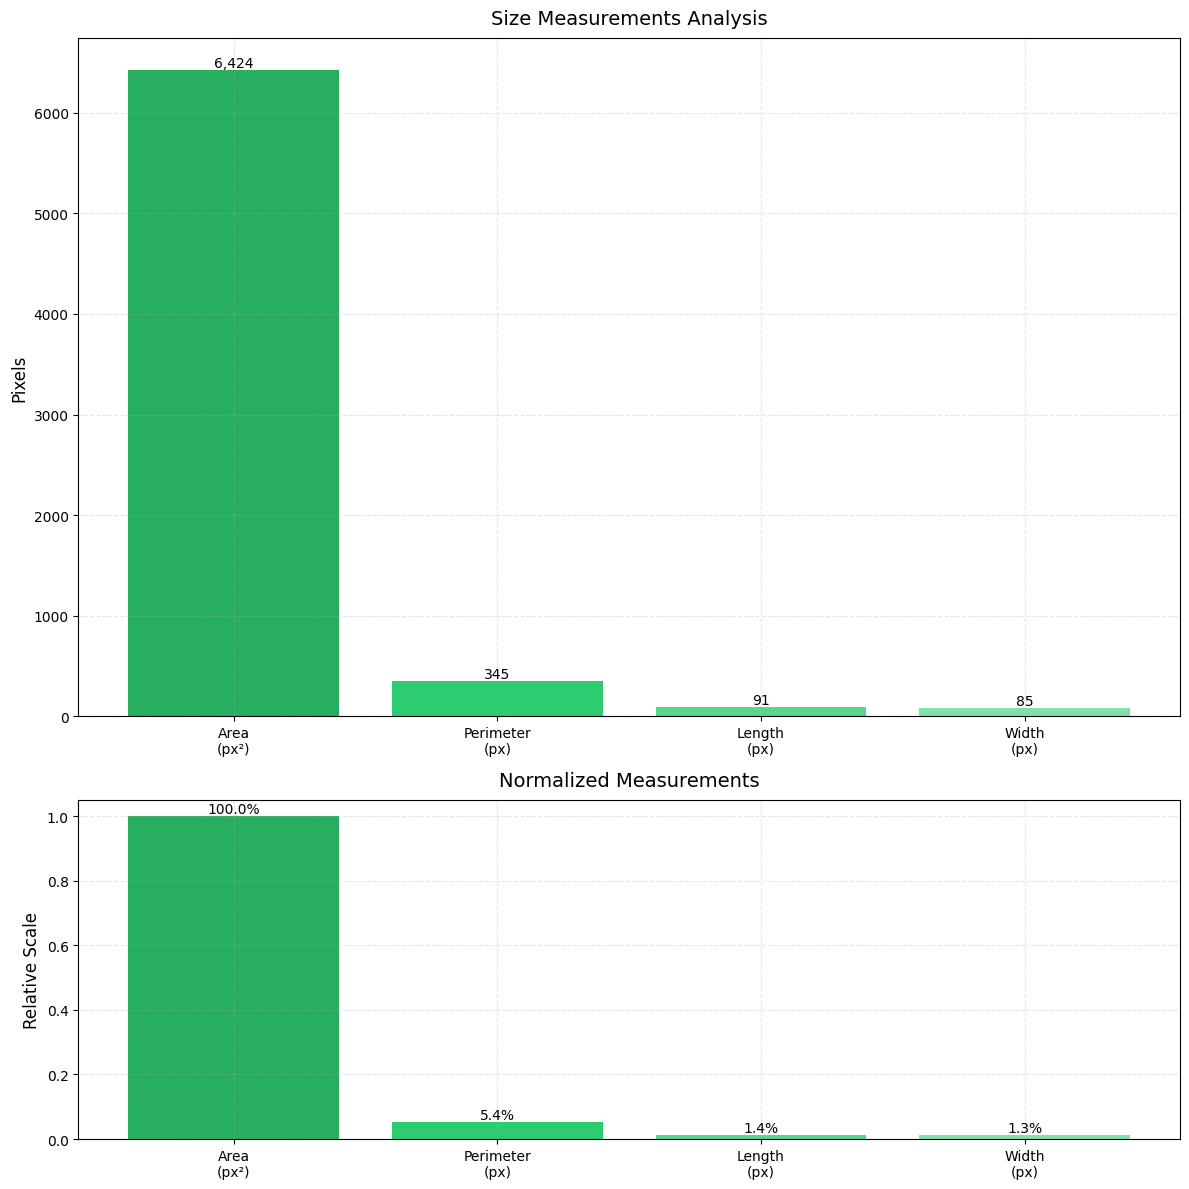

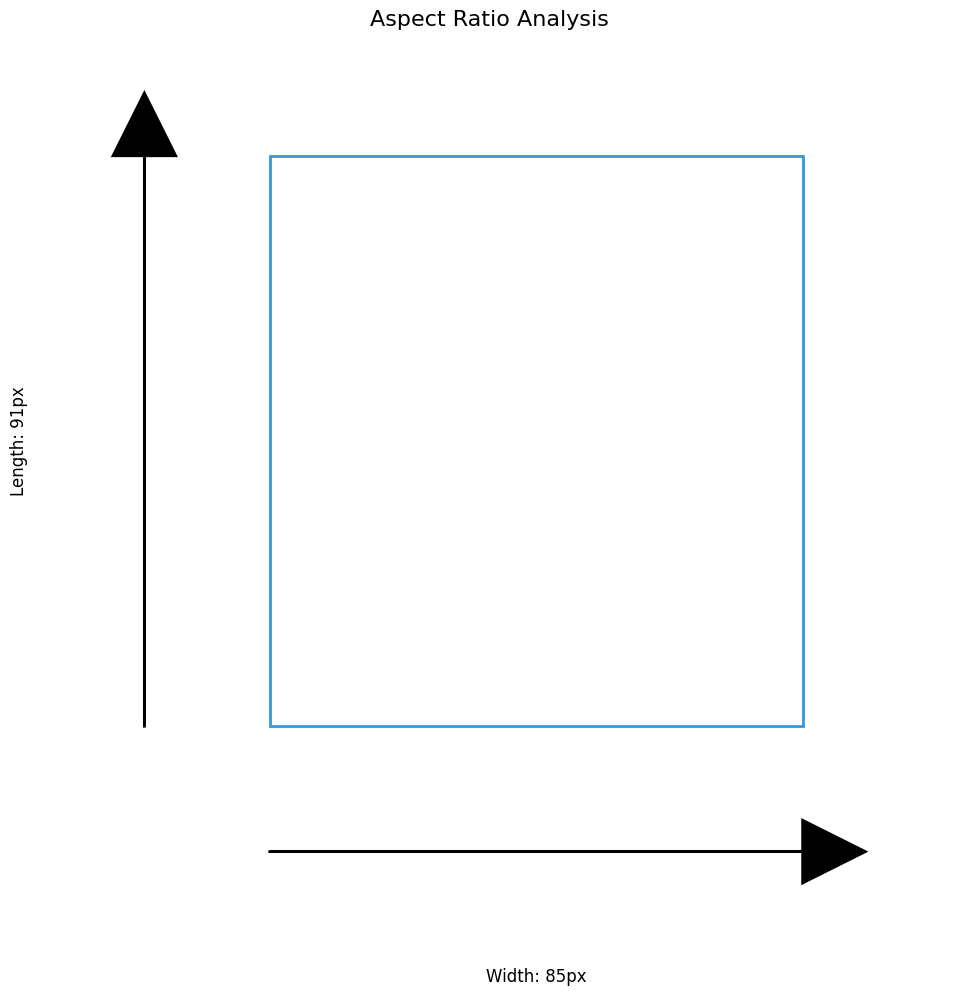

Measurement:  {'green_intensity': 145.71965890056342, 'color_uniformity': 0.9429798082471794, 'evi': 0.4822215019008203, 'tgi': 20.02998354816268, 'mcari': 0.255188431317506, 'vari': 0.35387233072395663, 'psri': 0.015135531452971347, 'green_entropy': 4.477004085368279, 'contrast': 0.4001487791172865, 'homogeneity': 0.9989251194392635, 'health_score': 0.981269986295112, 'chlorophyll_estimate': 0.11275689200607909}


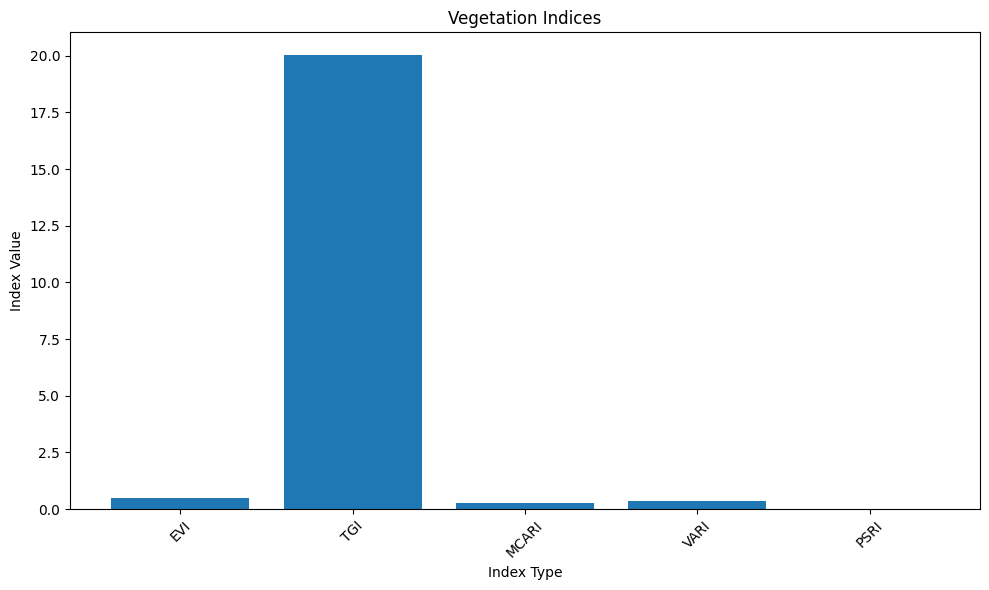

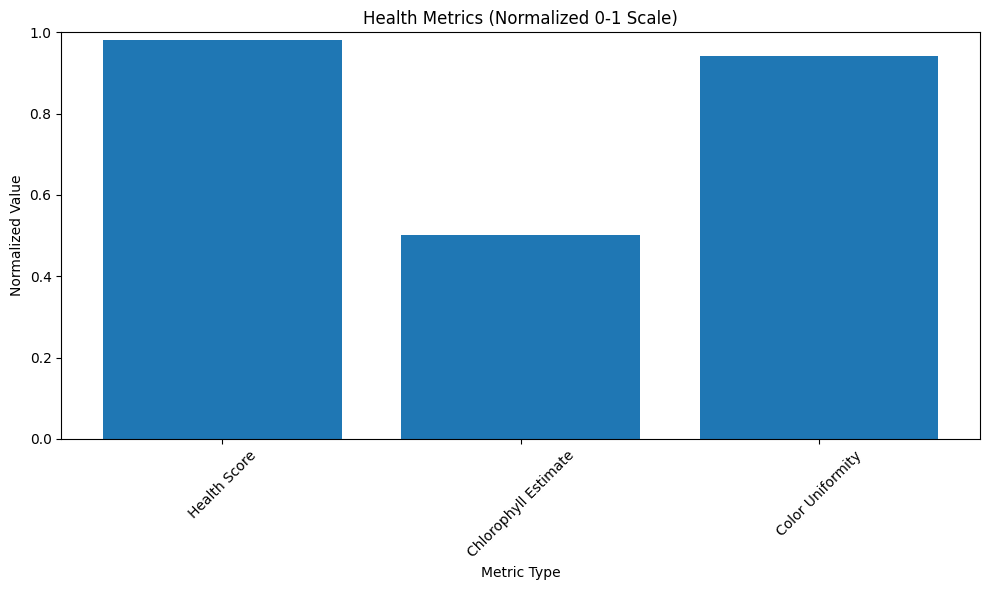

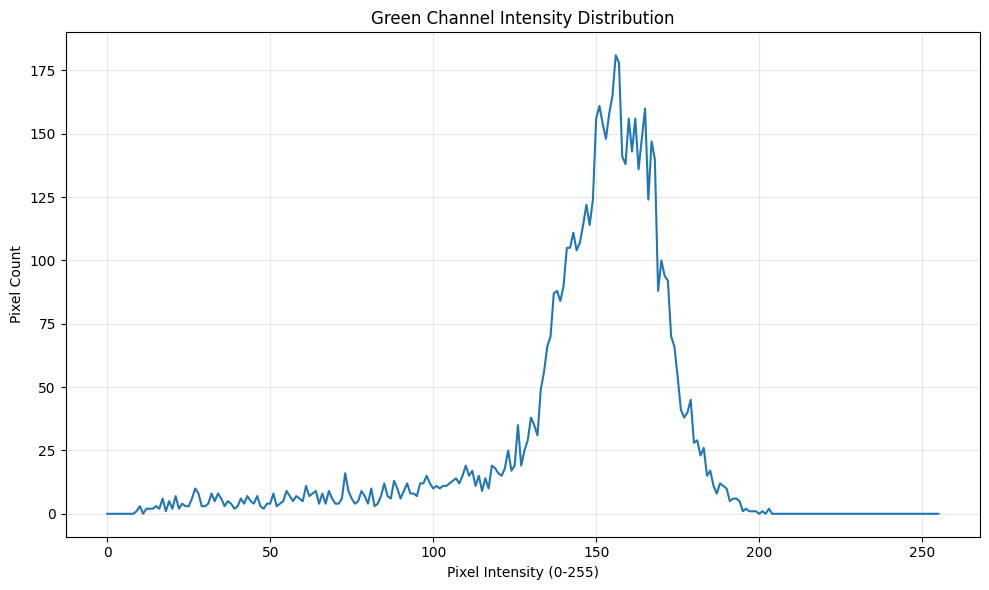

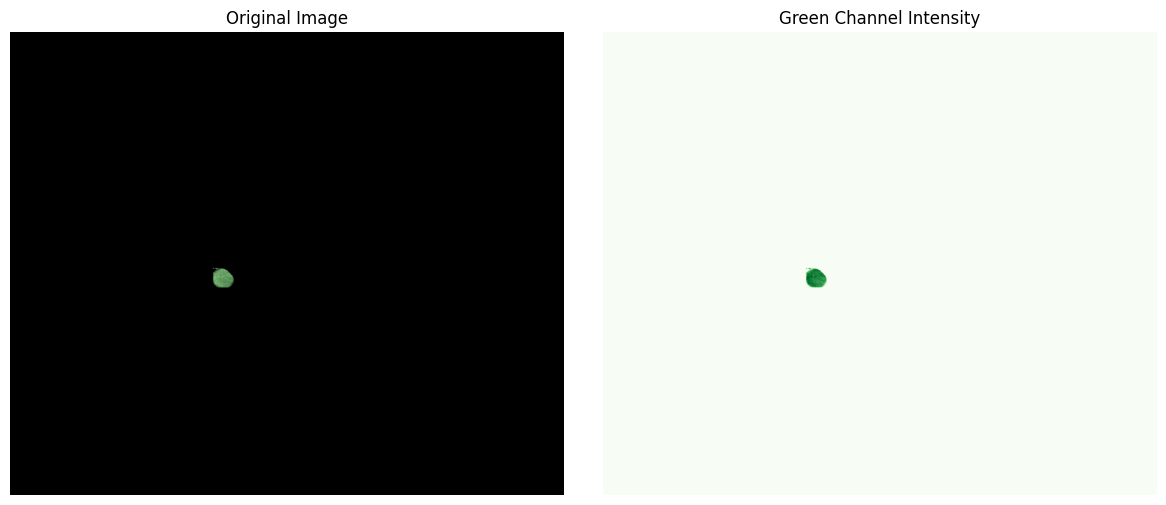

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>


Detailed Color Analysis Report

Vegetation Indices:
EVI: 0.482 (Enhanced Vegetation Index)
TGI: 20.030 (Triangular Greenness Index)
MCARI: 0.255 (Modified Chlorophyll Absorption Ratio Index)
VARI: 0.354 (Visible Atmospheric Resistant Index)
PSRI: 0.015 (Plant Senescence Reflectance Index)

Health Metrics:
Health Score: 0.981 (0-1 scale)
Chlorophyll Estimate: 0.113 (normalized)
Color Uniformity: 0.943 (0-1 scale)

Color Analysis:
Green Entropy: 4.477
Contrast: 0.400
Homogeneity: 0.999
Image shape: (2048, 2448, 3)
Mask shape: (2048, 2448)
Total leaf area (pixels): 6567.0

Stress areas and percentages:
chlorosis: 0 pixels, 0.00%
necrosis: 0 pixels, 0.00%
dark_spots: 535 pixels, 8.15%

Stress Analysis Results:
Chlorosis: 0.00%
Necrosis: 0.00%
Dark_spots: 8.15%
Overall Health: 91.85%


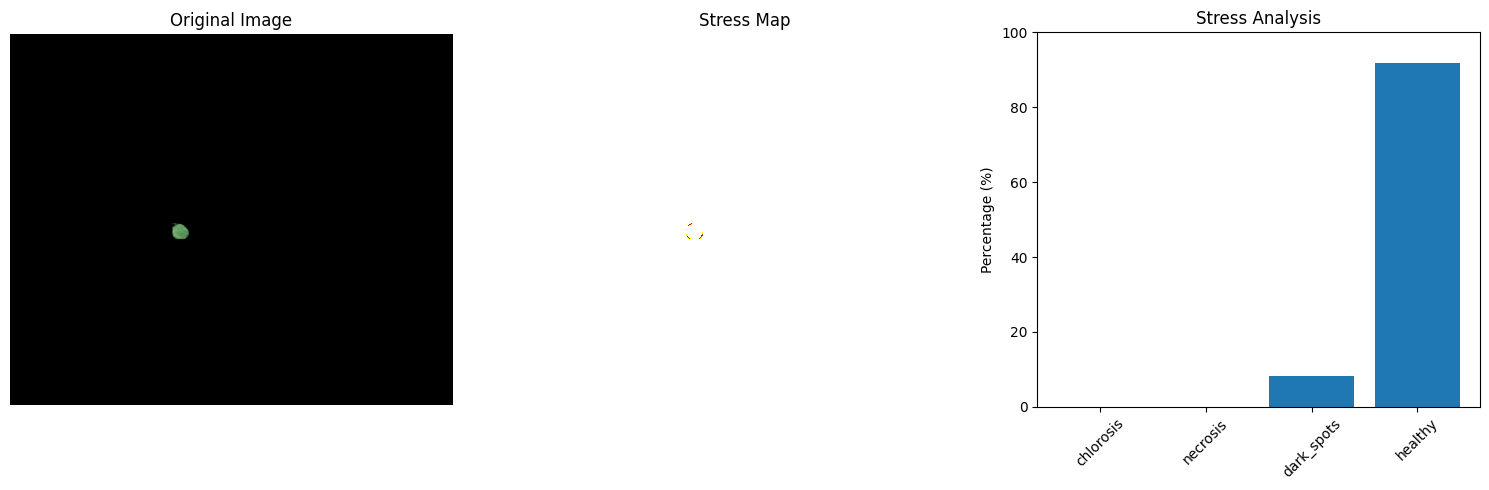

In [149]:
image_path = '/home/faisalnazir/Desktop/Sproj_Work/PlantPhenotyping/segmented/036/masked_object_1.png'
#Morphological Analysis
traits, figs = create_all_visualizations(image_path)
#Color Analysis
measurements, figs = analyze_leaf_color(image_path)
if isinstance(figs, list):
    for fig in figs:
        plt.figure(fig.number)
        plt.show()
else:
    plt.figure(figs.number)
    plt.show()

print_detailed_analysis(measurements)
#Stress Analysis
stress_analysis, fig = analyze_leaf_stress(image_path)
plt.show()

